# Coding
![Section Title: Coding](title_pict/coding2.png)

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from sklearn.metrics import accuracy_score

## Data
The following function returns a tuple containing the training and test datasets for a specified stock and time period.
- The training_ratio parameter represents the percentage of data allocated to the training set.

In [4]:
def get_training_test_data(stock='AMZN', start='2019-1-1', end='2021-1-31', training_ratio=0.96):
    df = yf.Ticker(stock).history(start=start, end=end)
    df = df.iloc[:,:-3]
    df.reset_index(inplace=True)
    df['Date'] = [i.date() for i in df.Date]
    df['fcc'] = [np.sign(df.Close.loc[i+1]-df.Close.loc[i]) for i in range(len(df)-1)]+[np.nan]
    training_length = int(len(df)*training_ratio)
    training_data = df.iloc[:training_length,:] 
    test_data = df.iloc[training_length:,:]
    test_data.reset_index(inplace=True, drop=True)
    return (training_data, test_data)

In [5]:
df_train, df_test = get_training_test_data()
df_train.shape, df_test.shape

((503, 6), (21, 6))

In [6]:
df_train.head()

,Date,Open,High,Low,Close,fcc
0,2019-01-02,73.260002,77.667999,73.046501,76.956497,-1.0
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,1.0
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,1.0
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,1.0
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,1.0


In [7]:
df_test.head()

,Date,Open,High,Low,Close,fcc
0,2020-12-30,167.050003,167.104996,164.123505,164.292496,-1.0
1,2020-12-31,163.750000,164.145996,162.059998,162.846497,-1.0
2,2021-01-04,163.500000,163.600006,157.201004,159.331497,1.0
3,2021-01-05,158.300507,161.169006,158.253006,160.925507,-1.0
4,2021-01-06,157.324005,159.875504,156.557999,156.919006,1.0


## Visualization

In [9]:
def cs_visualize(hp, op, cp, lp, x=0, details=False, linewidth=20):
    if cp > op: color = 'green'
    elif cp < op:  color = 'red'
    else: color ='black'

    plt.plot([x,x], [lp, hp], c=color)
    
    if cp != op:
        plt.plot([x,x], [op, cp], c=color, linewidth=linewidth)
    else:
        plt.plot([x-0.1,x+0.1], [op, cp], c=color, linewidth=1)

    if details:
        plt.text(x+0.01, hp, 'high')
        plt.text(x+0.01, lp , 'low')
        plt.text(x+0.01, cp, 'close')
        plt.text(x+0.01, op, 'open')

In [10]:
def cs_visualize_df(data, M=0, N=None):
    plt.figure(figsize=(20,5))
    for i in data.index[M:N]:
        hp, op, cp, lp = data[['High','Open', 'Close', 'Low']].loc[i]
        cs_visualize(hp, op, cp, lp, x=i)

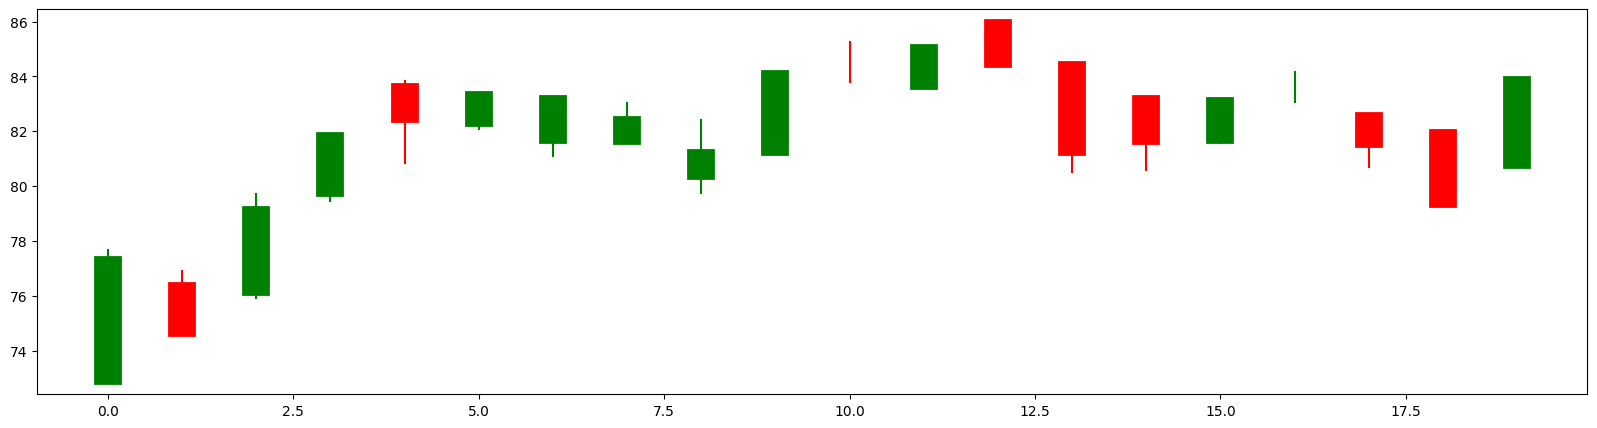

In [11]:
cs_visualize_df(df_train, M=0, N=20)

## Encoding


In [13]:
def encoder(hp, op, cp, lp):
    if hp  > op > cp  > lp: return 'a'
    if hp == op > cp  > lp: return 'b'
    if hp == op > cp == lp: return 'c'
    if hp  > op > cp == lp: return 'd'
        
    if hp  > cp > op  > lp: return 'e'
    if hp == cp > op  > lp: return 'f'
    if hp == cp > op == lp: return 'g'
    if hp  > cp > op == lp: return 'h'

    if hp  > op == cp  > lp: return 'i'
    if hp == op == cp  > lp: return 'j'
    if hp == op == cp == lp: return 'k'
    if hp  > op == cp == lp: return 'l' 

In [14]:
def df_encoder(data):
    data_ = data.copy()
    encoder_list = []
    for i in data_.index:
        hp, op, cp, lp = data_[['High','Open', 'Close', 'Low']].loc[i]
        encoder_list.append(encoder(hp, op, cp, lp))
    data_['code'] = encoder_list
    return data_

In [15]:
df_train = df_encoder(df_train)
df_train.head().round(2)

,Date,Open,High,Low,Close,fcc,code
0,2019-01-02,73.26,77.67,73.05,76.96,-1.0,e
1,2019-01-03,76.00,76.90,74.86,75.01,1.0,a
2,2019-01-04,76.50,79.70,75.92,78.77,1.0,e
3,2019-01-07,80.12,81.73,79.46,81.48,1.0,e
4,2019-01-08,83.23,83.83,80.83,82.83,1.0,a


The chart below illustrates the candlestick charts along with their corresponding codes.

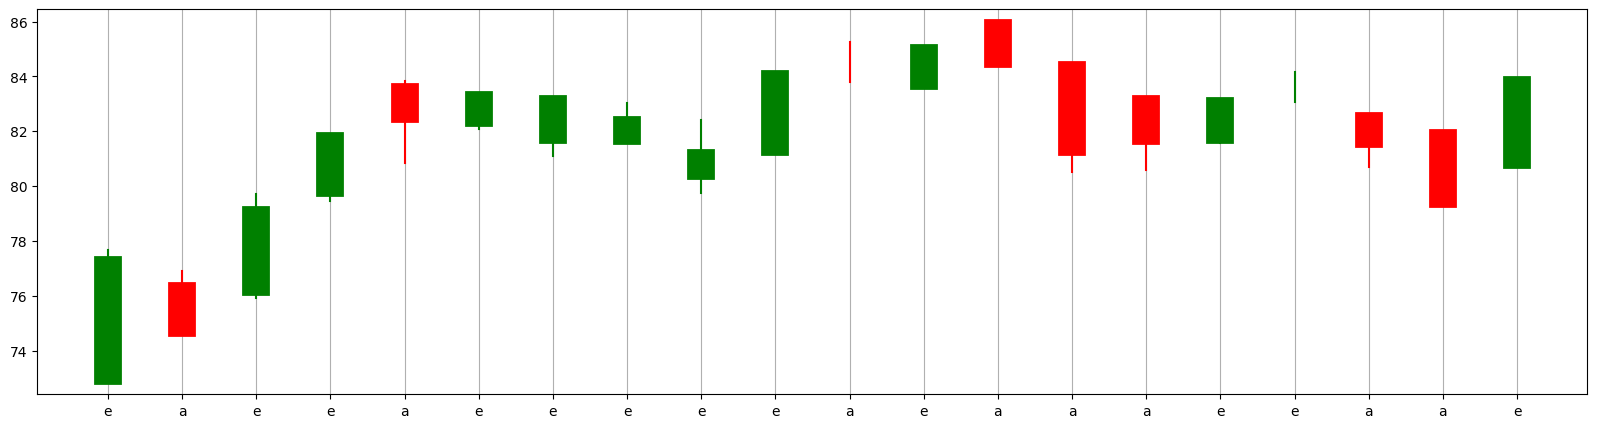

In [17]:
cs_visualize_df(df_train, M=0, N=20)
plt.xticks(range(0,20), df_train.code[0:20])
plt.grid(axis='x');

## Change Points

In [19]:
def change_points(data):
    data_ = data.copy()
    change_pts, change_types = [True], ['Start']

    for i in range(1, len(data_)-1):
        
        left_change  = int(np.sign(data_['Close'][i]-data_['Close'][i-1]))
        right_change = int(np.sign(data_['Close'][i+1]-data_['Close'][i]))
        
        if left_change != right_change:
            change_pts.append(True)
        else:
            change_pts.append(False)
            
        change_types.append((left_change, right_change))

    change_pts.append(False)
    change_types.append('End')

    data_['change_points'] = change_pts
    data_['change_types'] = change_types
    
    return data_

In [20]:
df_train = change_points(df_train)
df_train.head().round(2)

,Date,Open,High,Low,Close,fcc,code,change_points,change_types
0,2019-01-02,73.26,77.67,73.05,76.96,-1.0,e,True,Start
1,2019-01-03,76.00,76.90,74.86,75.01,1.0,a,True,"(-1, 1)"
2,2019-01-04,76.50,79.70,75.92,78.77,1.0,e,False,"(1, 1)"
3,2019-01-07,80.12,81.73,79.46,81.48,1.0,e,False,"(1, 1)"
4,2019-01-08,83.23,83.83,80.83,82.83,1.0,a,False,"(1, 1)"


In [21]:
df_train = change_points(df_train)
df_train.tail().round(2)

,Date,Open,High,Low,Close,fcc,code,change_points,change_types
498,2020-12-22,160.14,161.10,159.00,160.33,-1.0,e,True,"(1, -1)"
499,2020-12-23,160.25,160.51,159.21,159.26,-1.0,a,False,"(-1, -1)"
500,2020-12-24,159.70,160.10,158.45,158.63,1.0,a,True,"(-1, 1)"
501,2020-12-28,159.70,165.20,158.63,164.20,1.0,e,False,"(1, 1)"
502,2020-12-29,165.50,167.53,164.06,166.10,-1.0,e,False,End


In [22]:
def cp_visualizer(data, M=0, N=None):
    plt.figure(figsize=(20,5))
    plt.plot(data.index[M:N], data.Close[M:N], alpha=0.2)
    color_list = ['black', 'red']
    plt.scatter(data.index[M:N], data.Close[M:N], c=[color_list[i] for i in data.change_points[M:N]])
    plt.xticks(data.index[M:N], data.code[M:N], fontsize=12)
    plt.grid();

- In the graph of Close values below, the red points indicate the change points, while the x-values correspond to the candlestick code for each corresponding day.

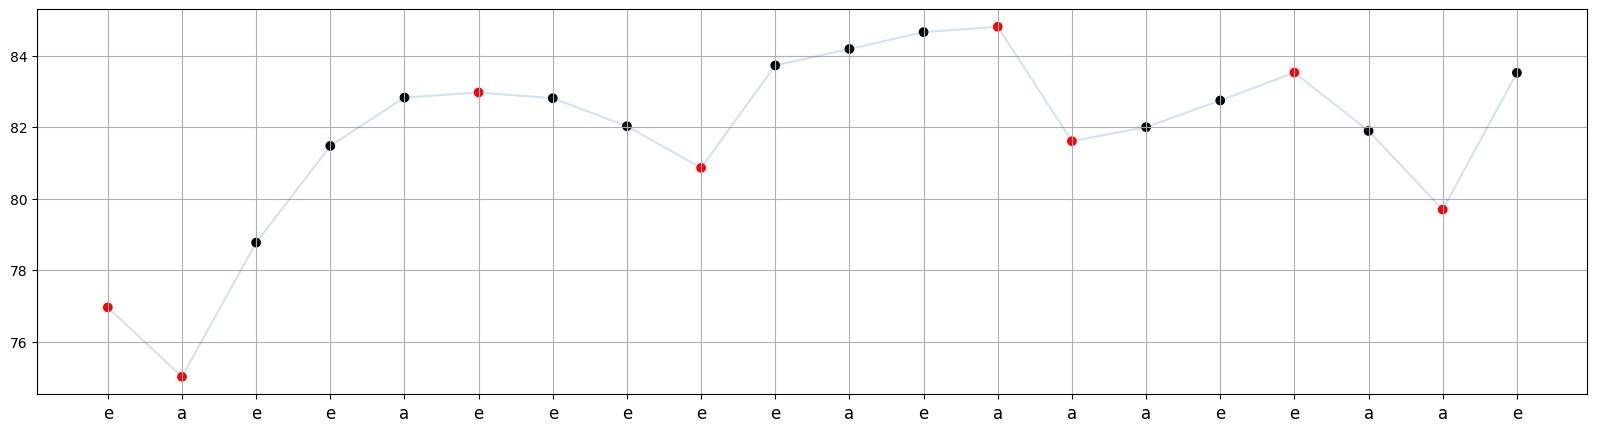

In [24]:
cp_visualizer(df_train, M=0, N=20)

## Segmentation and Labeling


In [26]:
def segmentation(data):
    segment_list, trend_list = [], []
    pattern = ''
    
    for i in range(len(data)-1):  
        pattern += data.code[i]
    
        if data.change_points.loc[i]:
            segment_list.append(pattern) 
            j = i
            while True:
                if data.change_types[j+1][0] != 0:   # first non-equal direction
                    trend_list.append(data.change_types[j+1][0]) 
                    break
                j += 1
    
            pattern = ''

    df_seg = pd.DataFrame()
    df_seg['kts'] = segment_list
    df_seg['trend'] = trend_list

    df_seg_unique = pd.DataFrame(df_seg.value_counts()).reset_index()

    return df_seg_unique

In [27]:
PSet = segmentation(df_train)
PSet.head()

,kts,trend,count
0,a,1,58
1,e,-1,47
2,aa,1,23
3,ee,-1,15
4,e,1,9


## Subsequence

In [29]:
def whethersub(X, Y):
    if len(X) > len(Y): return 0
    else:
        k = 0
        for i in range(len(X)):
            if X[i] in Y[k:]:
                k = Y.find(X[i], k)+1
            else:
                return 0          
    return 1 

## oNum

In [31]:
def onum(pset):
    pset_ = pset.copy()
    onum_list = []
    for i in range(len(pset)):
        total = 0
        for j in range(len(pset)):
            total += whethersub(pset_.loc[i, 'kts'], pset_.loc[j, 'kts'])* pset_.loc[j, 'count']
        onum_list.append(total)
    pset_['onum'] = onum_list
    return pset_

In [32]:
PRSet = onum(PSet)
PRSet.head()

,kts,trend,count,onum
0,a,1,58,154
1,e,-1,47,146
2,aa,1,23,58
3,ee,-1,15,60
4,e,1,9,146


## sameTrendNum


In [34]:
def sametrendnum(pset):
    pset_ = pset.copy()
    sametrendnum_list = []
    for i in range(len(pset_)):
        total = 0
        for j in range(len(pset_)):
            if whethersub(pset_.loc[i,'kts'], pset_.loc[j,'kts']) & (pset_.loc[i,'trend'] == pset_.loc[j, 'trend']):
                total += pset_.loc[j, 'count']    
        sametrendnum_list.append(total)
    pset_['sametrendnum'] = sametrendnum_list
    return pset_  

In [35]:
PRSet = sametrendnum(PRSet)
PRSet.head()

,kts,trend,count,onum,sametrendnum
0,a,1,58,154,111
1,e,-1,47,146,115
2,aa,1,23,58,47
3,ee,-1,15,60,56
4,e,1,9,146,31


## PACC


In [37]:
def pacc(pset):
    pset_ = pset.copy()
    pset_['pacc'] = pset_['sametrendnum'] / pset_['onum'] 
    return pset_

In [38]:
PRSet = pacc(PRSet)
PRSet.head().round(2)

,kts,trend,count,onum,sametrendnum,pacc
0,a,1,58,154,111,0.72
1,e,-1,47,146,115,0.79
2,aa,1,23,58,47,0.81
3,ee,-1,15,60,56,0.93
4,e,1,9,146,31,0.21


- The set described above is called the **Pattern Record Set (PRSet)**.
    - It consists of KTS-Trend pairs (KtsP) and their corresponding Pattern Accuracy Score (PACC) values.

## Subsequence Model

In [41]:
def subsequence_model_predict(kts, prset):
    best_pattern = []
    best_pacc = [0]
    best_trend = []
    for i in range(len(prset)):
        if (whethersub(prset.loc[i, 'kts'], kts)):
            if prset.loc[i, 'pacc'] > best_pacc[-1]:
                best_pattern = [prset.loc[i, 'kts']] 
                best_pacc = [prset.loc[i, 'pacc']]
                best_trend = [ prset.loc[i, 'trend']]
            elif prset.loc[i, 'pacc'] == best_pacc[-1]:
                best_pattern.append(prset.loc[i, 'kts'])
                best_pacc.append(prset.loc[i, 'pacc'])
                best_trend.append(prset.loc[i, 'trend'])

    if len(best_trend) == 0:
        pred = statistics.mode(prset.trend)
    elif len(best_trend) == 1:
        pred = best_trend[0]
    else:
        pred = statistics.mode(best_trend)
        
    return {'Best Pattern':best_pattern, 'Best PACC': best_pacc, 'Best Trend': best_trend, 'Prediction':pred}

In [42]:
subsequence_model_predict('aaee', PRSet)

{'Best Pattern': ['ee'],
 'Best PACC': [0.9333333333333333],
 'Best Trend': [-1],
 'Prediction': -1}

In [43]:
subsequence_model_predict('acd', PRSet)

{'Best Pattern': ['a'],
 'Best PACC': [0.7207792207792207],
 'Best Trend': [1],
 'Prediction': 1}

## Test Set

In [45]:
df_test.head().round(2)

,Date,Open,High,Low,Close,fcc
0,2020-12-30,167.05,167.10,164.12,164.29,-1.0
1,2020-12-31,163.75,164.15,162.06,162.85,-1.0
2,2021-01-04,163.50,163.60,157.20,159.33,1.0
3,2021-01-05,158.30,161.17,158.25,160.93,-1.0
4,2021-01-06,157.32,159.88,156.56,156.92,1.0


In [48]:
df_test = df_encoder(df_test)
df_test.head().round(2)

,Date,Open,High,Low,Close,fcc,code
0,2020-12-30,167.05,167.10,164.12,164.29,-1.0,a
1,2020-12-31,163.75,164.15,162.06,162.85,-1.0,a
2,2021-01-04,163.50,163.60,157.20,159.33,1.0,a
3,2021-01-05,158.30,161.17,158.25,160.93,-1.0,e
4,2021-01-06,157.32,159.88,156.56,156.92,1.0,a


In [50]:
def test_data_prep(data, N=5):
    test_data = []
    for i in range(len(data)-N):
        kts = ''
        for j in range(N):
            kts += data.code.loc[i+j]
        test_data.append((kts, data.fcc.loc[i+j]))
        
    if type(test_data[-1][-1]) != float:
        test_data.pop()
    
    return test_data

In [52]:
test_data = test_data_prep(df_test)
test_data

[('aaaea', 1.0),
 ('aaeae', 1.0),
 ('aeaee', -1.0),
 ('eaeea', 1.0),
 ('aeeae', 1.0),
 ('eeaee', -1.0),
 ('eaeea', -1.0),
 ('aeeaa', 1.0),
 ('eeaae', 1.0),
 ('eaaee', 1.0),
 ('aaeee', -1.0),
 ('aeeea', 1.0),
 ('eeeaa', 1.0),
 ('eeaae', -1.0),
 ('eaaea', 1.0)]

## Prediction

In [55]:
def subsequence_model_score(data, prset):
    pred_trend_test = [subsequence_model_predict(kts, prset)['Prediction'] for (kts,trend) in data]
    actual_trend_test = [trend for (kts,trend) in data]
    return accuracy_score(pred_trend_test,  actual_trend_test)

In [57]:
subsequence_model_score(test_data, PRSet)

0.6